In [1]:
# import the libraries
import pandas as pd 
import numpy as np 
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [2]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [3]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [4]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [5]:
# Fill the nan values with 0 for the comospition columns
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)
tensile_df['Irradiation Dose (mdpa)']  = tensile_df['Irradiation Dose (mdpa)'].fillna(0)
tensile_df['Irradiation Temperature (C)']  = tensile_df['Irradiation Temperature (C)'].fillna(0)

In [6]:
# check these columns that have noisy data. 
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 'bal' 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.21 0.09 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 '150-400ppm' '<40 ppm' 0.12 0.064 0.061 0.063 0.06
 0.05 0.04 0.058 0.009 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039
 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 96.828 90.174
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 0.165 '<0.6'
 99.19 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.15

In [7]:
# Clean the data
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]


In [8]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.21 0.09 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 0.12 0.064 0.061 0.063 0.06 0.05 0.04 0.058 0.009
 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 96.828 90.174
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 99.19
 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.1522 65.0159999999999 65.7088 64.6432 64.9213

In [9]:
# convert all of the composition columns' data type to float
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [10]:
# Select SS316 stainless steel and sub-sized samples
tensile_df  = tensile_df[(tensile_df['Material Group'].str.contains('ss316', case=False))& (tensile_df['Specimen Size'] == 'Sub-sized')]

In [11]:
# Drop the columns that don't have  enough data records. 

tensile_df = tensile_df.drop(columns=[ 'Reference','Manufacturing','Cooling', 'Material', 'Treatment','Specimen Size Type',
                                       'Irradiation Time (h)', 'Fillet Radius (mm)', 'Specimen Size', 'Specimen Shape',
                                       'Post Treatment Temperature (C)','Post Treatment Time (h)','Microstructure', 'Aspect Ratio (R/W)', 'Ultimate Tensile Strength (MPa)',
                                       'Yield Strength (MPa)', 'Total Elongation (%)','Specimen Shape'
                                       ])


In [12]:
# remove nan values from the dataset
tensile_df = tensile_df.dropna()
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 21 to 703
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Material Group                86 non-null     object 
 1   C (wt.%)                      86 non-null     float64
 2   Si (wt.%)                     86 non-null     float64
 3   Mn (wt.%)                     86 non-null     float64
 4   P (wt.%)                      86 non-null     float64
 5   S (wt.%)                      86 non-null     float64
 6   Ni (wt.%)                     86 non-null     float64
 7   Cr (wt.%)                     86 non-null     float64
 8   Mo (wt.%)                     86 non-null     float64
 9   Al (wt.%)                     86 non-null     float64
 10  N (wt.%)                      86 non-null     float64
 11  Ti (wt.%)                     86 non-null     float64
 12  Fe (wt.%)                     86 non-null     float64
 13  Nb (wt.%) 

In [13]:
# sort the data by UE values
tensile_df = tensile_df.sort_values(by='Uniform Elongation (%)').reset_index(drop=True)


In [14]:
# Select columns for modeling. 

input_features_df =  tensile_df.drop(columns=['Uniform Elongation (%)'])

In [15]:
# Encode the categorical columns 
input_features_df['Material Group'] = input_features_df['Material Group'].astype('category')
input_features_df['Material Group'] = input_features_df['Material Group'].cat.codes

input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].astype('category')
input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].cat.codes

In [16]:
# make sure all the input features data is float data type
input_features_df = input_features_df.astype('float')

In [17]:
# define input features and input targets
features = input_features_df
targets = tensile_df['Uniform Elongation (%)']

In [18]:
# define coverage
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
[iter 0] loss=4.3940 val_loss=4.2289 scale=2.0000 norm=2.3229


[iter 100] loss=3.7219 val_loss=3.4267 scale=2.0000 norm=1.2081
[iter 200] loss=3.2409 val_loss=2.9603 scale=2.0000 norm=1.0153
[iter 300] loss=2.7834 val_loss=2.5927 scale=2.0000 norm=0.9694
[iter 400] loss=2.3580 val_loss=2.3948 scale=2.0000 norm=0.9235
== Early stopping achieved.
== Best iteration / VAL409 (val_loss=2.3915)
Pearson CC: 0.992657423350054
R2 score: 0.9845987275181763
RMSE: 2.1423805198053167
MAE: 1.3780830836926934
Coverage: 100.0
Median Interval Width: 22.235039394846602
Composite Metric: 0.7612435150467034


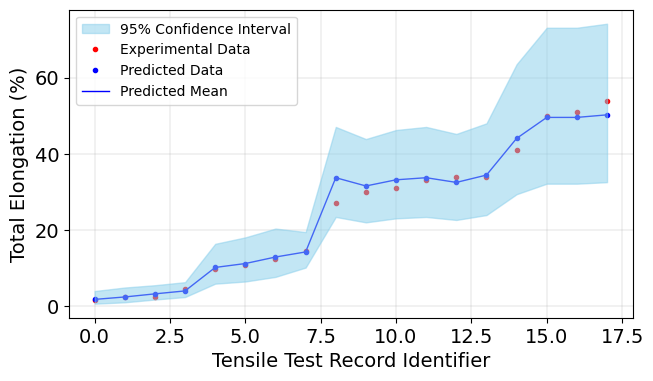

Run # 1 Fold # 2
[iter 0] loss=4.3321 val_loss=3.8623 scale=2.0000 norm=2.2487
[iter 100] loss=3.6566 val_loss=3.0361 scale=2.0000 norm=1.1888
[iter 200] loss=3.1790 val_loss=2.5909 scale=2.0000 norm=1.0033
[iter 300] loss=2.7313 val_loss=2.2103 scale=2.0000 norm=0.9535
[iter 400] loss=2.3232 val_loss=1.9279 scale=2.0000 norm=0.9040
[iter 500] loss=1.9892 val_loss=1.7808 scale=2.0000 norm=0.8468
== Early stopping achieved.
== Best iteration / VAL552 (val_loss=1.7623)
Pearson CC: 0.9870024166399172
R2 score: 0.9620976063797826
RMSE: 4.3677623445529346
MAE: 2.58382261981318
Coverage: 94.11764705882354
Median Interval Width: 19.414660489201047
Composite Metric: 0.718759219891235


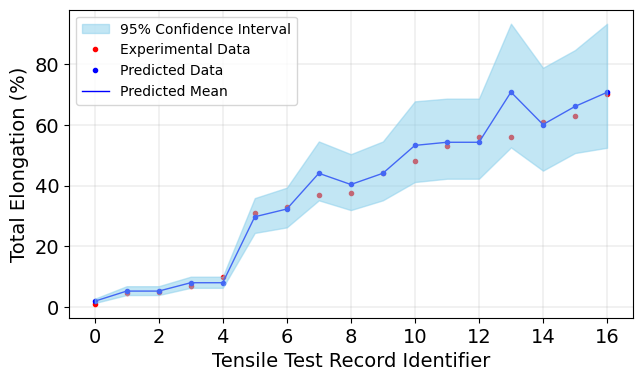

Run # 1 Fold # 3
[iter 0] loss=4.5209 val_loss=4.2234 scale=2.0000 norm=2.0657
[iter 100] loss=3.8120 val_loss=3.2463 scale=2.0000 norm=1.1310
[iter 200] loss=3.3301 val_loss=2.7697 scale=2.0000 norm=0.9858
[iter 300] loss=2.8712 val_loss=2.3640 scale=2.0000 norm=0.9438
[iter 400] loss=2.4428 val_loss=2.0742 scale=2.0000 norm=0.8968
== Early stopping achieved.
== Best iteration / VAL468 (val_loss=1.9776)
Pearson CC: 0.9723113721606231
R2 score: 0.9266752346058811
RMSE: 5.832950860759983
MAE: 2.6783344833887304
Coverage: 88.23529411764707
Median Interval Width: 3.3572131087215284
Composite Metric: 0.7362312327020352


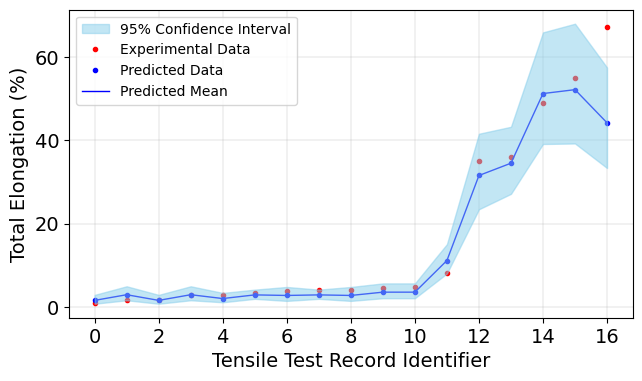

Run # 1 Fold # 4
[iter 0] loss=4.4948 val_loss=4.0742 scale=2.0000 norm=2.3105
[iter 100] loss=3.8080 val_loss=3.2076 scale=2.0000 norm=1.1952
[iter 200] loss=3.3152 val_loss=2.7641 scale=2.0000 norm=1.0055
[iter 300] loss=2.8426 val_loss=2.4166 scale=2.0000 norm=0.9689
[iter 400] loss=2.4006 val_loss=2.2750 scale=2.0000 norm=0.9276
== Early stopping achieved.
== Best iteration / VAL400 (val_loss=2.2750)
Pearson CC: 0.9910696889404207
R2 score: 0.9813793012760172
RMSE: 2.338200140870886
MAE: 1.7524079248318984
Coverage: 100.0
Median Interval Width: 11.003426430623275
Composite Metric: 0.772720195529661


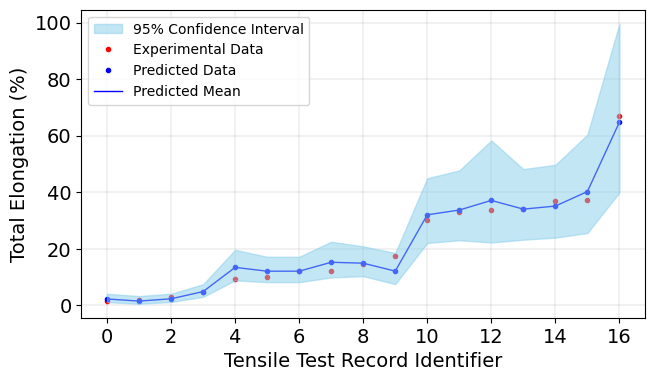

Run # 1 Fold # 5
[iter 0] loss=4.3784 val_loss=3.8669 scale=2.0000 norm=2.3205
[iter 100] loss=3.7173 val_loss=3.0947 scale=2.0000 norm=1.2109
[iter 200] loss=3.2334 val_loss=2.6756 scale=2.0000 norm=1.0076
[iter 300] loss=2.7793 val_loss=2.3740 scale=2.0000 norm=0.9589
== Early stopping achieved.
== Best iteration / VAL378 (val_loss=2.2902)
Pearson CC: 0.9825627284613239
R2 score: 0.9489791002713046
RMSE: 4.788360687711959
MAE: 3.2840776735835613
Coverage: 88.23529411764707
Median Interval Width: 27.915730657113254
Composite Metric: 0.6707202300300363


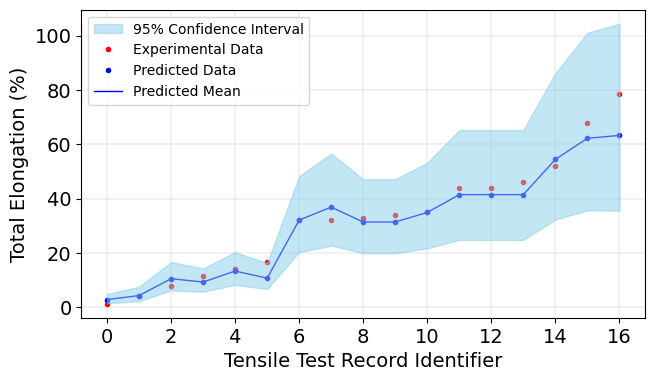

In [19]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):
            
            # Display the run number
            print('Run #', j+1, "Fold #", i+1)
            
            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]
            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)
            
            X_train, X_val, y_train, Y_val =train_test_split(X_train, y_train, test_size=0.2, random_state=42)
            
            
            model = NGBRegressor(Dist=LogNormal, n_estimators=1000, learning_rate=0.005)

            model.fit(X_train, y_train, X_val=X_val, Y_val=Y_val, early_stopping_rounds=4)

            y_pred_test = model.predict(X_test)
            
            y_test_ngb = model.pred_dist(X_test)

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))
            
            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            
            df_test_low = y_test_ngb.interval(0.95)[0]
            df_test_median = y_pred_test
            df_test_high = y_test_ngb.interval(0.95)[1]
            
            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high) 
            print(f'Coverage: {test_coverage[j, i]}')

            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test
            y_std = np.std(np.array(y_pred_test), axis=0)

            ax[0].fill_between(iteration_list, df_test_low, df_test_high, alpha=0.5, color='skyblue', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ro', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'bo', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="blue", label="Predicted Mean")
            ax[0].legend(fontsize=10, frameon=True, loc="upper left")
            ax[0].set_xlabel("Tensile Test Record Identifier", fontsize=14)
            ax[0].set_ylabel("Total Elongation (%)", fontsize=14)
            ax[0].tick_params(axis='x', labelsize=14)  
            ax[0].tick_params(axis='y', labelsize=14)   

            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])
            plt.show()

In [20]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.992657,0.984599,2.142381,1.378083,100.000000
1,0.987002,0.962098,4.367762,2.583823,94.117647
2,0.972311,0.926675,5.832951,2.678334,88.235294
3,0.991070,0.981379,2.338200,1.752408,100.000000
4,0.982563,0.948979,4.788361,3.284078,88.235294


In [21]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.985121,0.007299,0.960746,0.021428,3.893931,1.433356,2.335345,0.683468,94.117647,5.261336


In [24]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten()},index=None)
df3

,Coverage,Interval Width
0,100.000000,22.235039
1,94.117647,19.414660
2,88.235294,3.357213
3,100.000000,11.003426
4,88.235294,27.915731


In [25]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)

median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)

median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                 },index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std
0,94.117647,5.261336,16.785214,8.651512
